In [1]:
interp.repositories() ++= Seq(
  coursierapi.MavenRepository.of("https://dl.bintray.com/cibotech/public")
)

In [2]:
import $ivy.{
    `org.apache.spark::spark-sql:3.0.0`,
    `com.cibo::evilplot-repl:0.8.0`
}

import $ivy.$                                                                               

In [3]:
import java.io.FileWriter
import java.time.LocalDate

import scala.io.Source

import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._
import org.apache.spark.sql.expressions.Window

import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)

val spark = {
  NotebookSparkSession.builder()
    .master("local[*]")
    .getOrCreate()
}

import spark.implicits._

Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

import java.io.FileWriter

import java.time.LocalDate


import scala.io.Source


import org.apache.spark.sql._

import org.apache.spark.sql.functions._

import org.apache.spark.sql.types._

import org.apache.spark.sql.expressions.Window


import org.apache.log4j.{Level, Logger}

spark: SparkSession = org.apache.spark.sql.SparkSession@430aab15
import spark.implicits._

In [4]:
val now = LocalDate.now
val csvUrl = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
val csvFile = s"covid-$now.csv"

now: LocalDate = 2020-07-25
csvUrl: String = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
csvFile: String = "covid-2020-07-25.csv"

In [ ]:
{
    val src = Source.fromURL(csvUrl)
    val out = new java.io.FileWriter(csvFile)
    out.write(src.mkString)
    out.close
}

In [5]:
val df = spark.read
  .option("header", true)
  .csv(csvFile)

csv at cmd4.sc:3

1 / 1

df: DataFrame = [dateRep: string, day: string ... 10 more fields]

In [6]:
df.where("geoId = 'EL'").orderBy("dateRep").show(100,false)

show at cmd5.sc:1

1 / 1

+----------+---+-----+----+-----+------+-----------------------+-----+--------------------+-----------+------------+----------------------------------------------------------+
|dateRep   |day|month|year|cases|deaths|countriesAndTerritories|geoId|countryterritoryCode|popData2019|continentExp|Cumulative_number_for_14_days_of_COVID-19_cases_per_100000|
+----------+---+-----+----+-----+------+-----------------------+-----+--------------------+-----------+------------+----------------------------------------------------------+
|01/01/2020|1  |1    |2020|0    |0     |Greece                 |EL   |GRC                 |10724599   |Europe      |null                                                      |
|01/02/2020|1  |2    |2020|0    |0     |Greece                 |EL   |GRC                 |10724599   |Europe      |0                                                         |
|01/03/2020|1  |3    |2020|3    |0     |Greece                 |EL   |GRC                 |10724599   |Europe      |0.06

In [7]:
val byDate = Window.partitionBy("country").orderBy("date")
val byWeek = Window.orderBy($"week").rowsBetween(Window.unboundedPreceding, Window.currentRow)

byDate: expressions.WindowSpec = org.apache.spark.sql.expressions.WindowSpec@16f73a69
byWeek: expressions.WindowSpec = org.apache.spark.sql.expressions.WindowSpec@28991f78

In [8]:
val df_sums = df
  .select(
      to_date(col("dateRep"),"dd/MM/yyyy").as("date"), 
      $"geoId".alias("country"),
      $"cases".cast("int"), 
      $"deaths".cast("int"))
  .withColumn("rank", rank().over(byDate))
  .withColumn("week", lit($"rank"/7).cast("int"))
  .withColumn("d_week", first("date").over(Window.partitionBy("week")))
  .drop("rank", "date")
  .groupBy("country", "week", "d_week")
  .agg(sum("cases").alias("w_cases"),sum("deaths").alias("w_deaths"))
  .withColumn("cases_cumulative", sum("w_cases").over(byWeek))
  .withColumn("deaths_cumulative", sum("w_deaths").over(byWeek))
  .cache

df_sums: Dataset[Row] = [country: string, week: int ... 5 more fields]

In [9]:
val balkans = Seq("MK", "AL", "BA", "BG", "ME", "HR", "EL", "RO", "RS", "SI").toDF("cc")
val eu = Seq("BE", "EL", "LT", "PT", "BG", "ES", "LU", "RO", "CZ", "FR", "HU", "SI", "DK", "HR", "MT", "SK", "DE", "IT", "NL", "FI", "EE", "CY", "AT", "SE", "IE", "LV", "PL").toDF("cc")

balkans: DataFrame = [cc: string]
eu: DataFrame = [cc: string]

In [10]:
val df_balkans = balkans
  .join(df_sums, $"country" === $"cc")
  .groupBy("week", "d_week")
  .agg(
      sum("w_cases").alias("w_cases"), 
      sum("w_deaths").alias("w_deaths"), 
      sum("cases_cumulative").alias("cases_cumulative"), 
      sum("deaths_cumulative").alias("deaths_cumulative"))
  .withColumn("country", lit("BALKANS"))
  .select("country", "week", "d_week", "w_cases", "w_deaths", "cases_cumulative", "deaths_cumulative")
  .cache

df_balkans: Dataset[Row] = [country: string, week: int ... 5 more fields]

In [11]:
val df_eu = eu
  .join(df_sums, $"country" === $"cc")
  .groupBy("week", "d_week")
  .agg(
      sum("w_cases").alias("w_cases"), 
      sum("w_deaths").alias("w_deaths"), 
      sum("cases_cumulative").alias("cases_cumulative"), 
      sum("deaths_cumulative").alias("deaths_cumulative"))
  .withColumn("country", lit("EU"))
  .select("country", "week", "d_week", "w_cases", "w_deaths", "cases_cumulative", "deaths_cumulative")
  .cache

df_eu: Dataset[Row] = [country: string, week: int ... 5 more fields]

In [12]:
val df_world = df_sums
  .groupBy("week", "d_week")
  .agg(
      sum("w_cases").alias("w_cases"), 
      sum("w_deaths").alias("w_deaths"), 
      sum("cases_cumulative").alias("cases_cumulative"), 
      sum("deaths_cumulative").alias("deaths_cumulative"))
  .withColumn("country", lit("WORLD"))
  .select("country", "week", "d_week", "w_cases", "w_deaths", "cases_cumulative", "deaths_cumulative")
  .cache

df_world: Dataset[Row] = [country: string, week: int ... 5 more fields]

In [13]:
val df_union = df_sums.union(df_eu).union(df_balkans).union(df_world).cache

df_union: Dataset[Row] = [country: string, week: int ... 5 more fields]

In [14]:
import com.cibo.evilplot.colors.RGB
import com.cibo.evilplot.geometry.{Align, Drawable, Extent, Rect, Text}
import com.cibo.evilplot.plot._
import com.cibo.evilplot.plot.aesthetics.DefaultTheme.{DefaultTheme, DefaultFonts}
import com.cibo.evilplot.plot.renderers.BarRenderer
import com.cibo.evilplot.numeric._

def showPlot(plot: com.cibo.evilplot.geometry.Drawable) =
  Image.fromRenderedImage(plot.asBufferedImage, Image.PNG)

def renderCountry(country: String, df: DataFrame) = {

  implicit val theme = DefaultTheme.copy(fonts = DefaultFonts.copy(tickLabelSize = 5))
    
  val (firstPair, secondPair) = df
    .select(date_format($"d_week", "dd/MM"), $"week", $"w_cases", $"w_deaths")
    .where(s"country = '$country'")
    .orderBy("week")
    .collect
    .map(r => ( (r(0).toString, r(1).toString.toDouble), (r(2).toString.toDouble, r(3).toString.toDouble)) )
    .unzip

  val (weekDate, week) = firstPair.toList.unzip
  val (cases, deaths) = secondPair.toList.unzip
    
  val caseLine = week.zip(cases).map(v => Point(v._1,v._2))
  val deathLine = week.zip(deaths).map(v => Point(v._1,v._2))

  val plot1 = LinePlot(caseLine).standard(weekDate).title(s"$country: Cases")
  val plot2 = LinePlot(deathLine).standard(weekDate).title(s"$country: Deaths")

  val plot = Facets(Seq(Seq(plot1, plot2))).render(Extent(1200,300))

  showPlot(plot)
   
}


import com.cibo.evilplot.colors.RGB

import com.cibo.evilplot.geometry.{Align, Drawable, Extent, Rect, Text}

import com.cibo.evilplot.plot._

import com.cibo.evilplot.plot.aesthetics.DefaultTheme.{DefaultTheme, DefaultFonts}

import com.cibo.evilplot.plot.renderers.BarRenderer

import com.cibo.evilplot.numeric._


defined function showPlot
defined function renderCountry

collect at cmd13.sc:18

4 / 4

collect at cmd13.sc:18

4 / 4

collect at cmd13.sc:18

30 / 30

collect at cmd13.sc:18

4 / 4

collect at cmd13.sc:18

4 / 4

collect at cmd13.sc:18

30 / 30

collect at cmd13.sc:18

4 / 4

collect at cmd13.sc:18

4 / 4

collect at cmd13.sc:18

30 / 30

collect at cmd13.sc:18

4 / 4

collect at cmd13.sc:18

4 / 4

collect at cmd13.sc:18

30 / 30

collect at cmd13.sc:18

4 / 4

collect at cmd13.sc:18

4 / 4

collect at cmd13.sc:18

30 / 30

collect at cmd13.sc:18

4 / 4

collect at cmd13.sc:18

4 / 4

collect at cmd13.sc:18

30 / 30

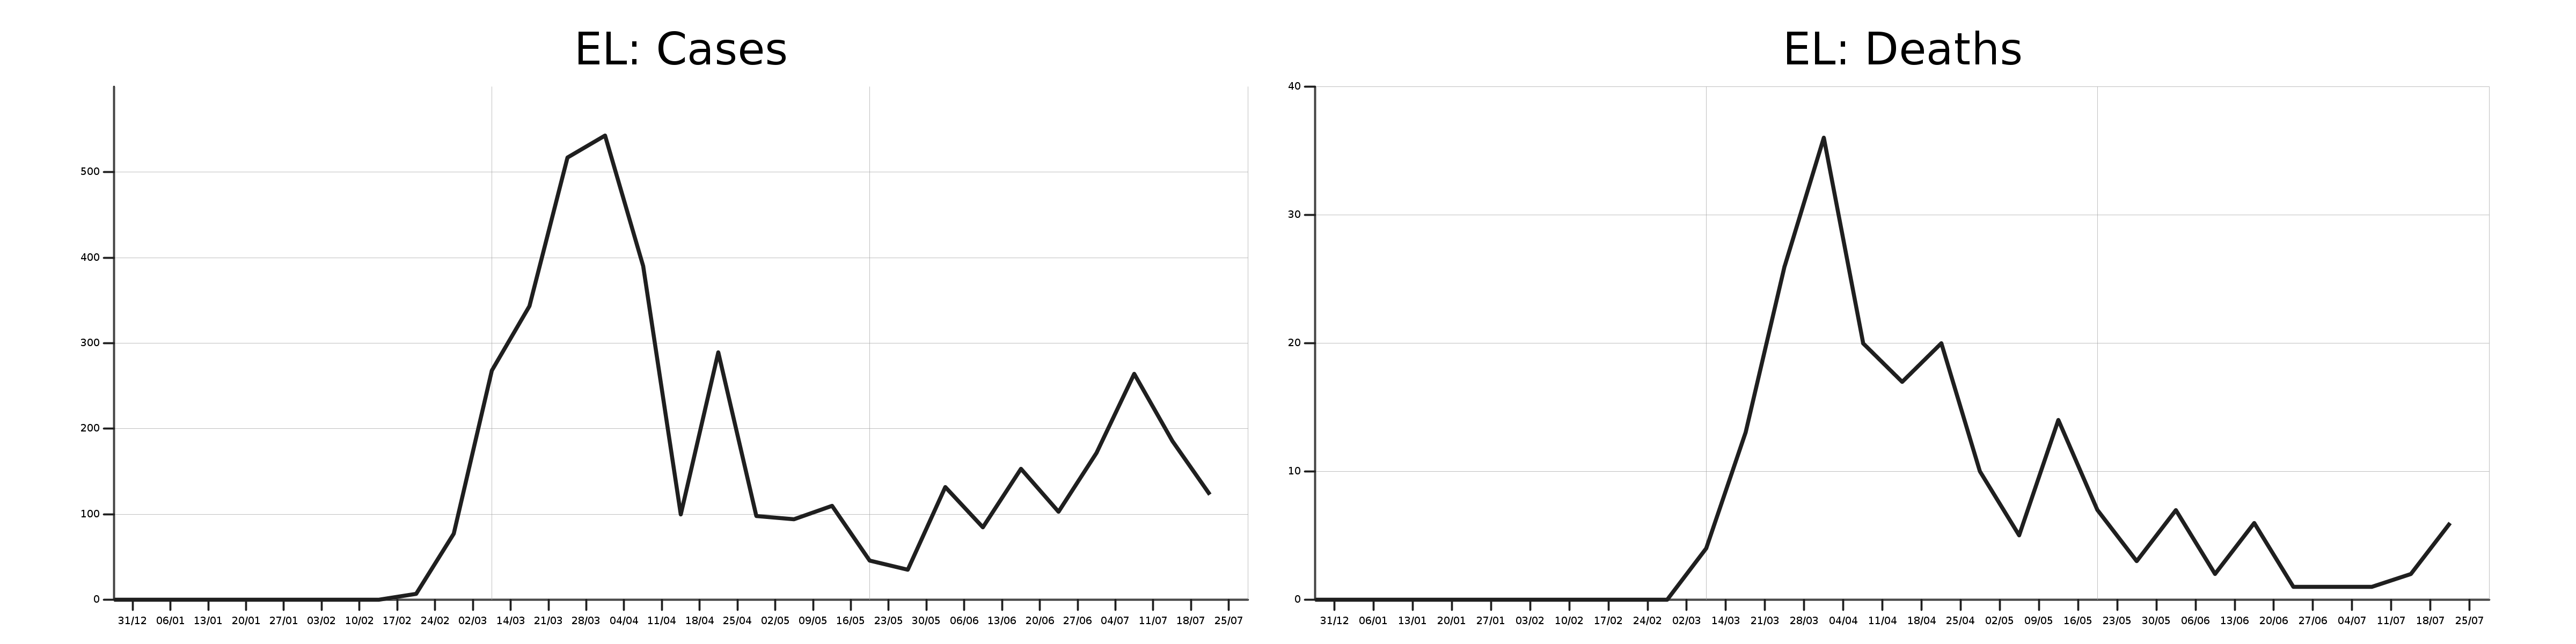

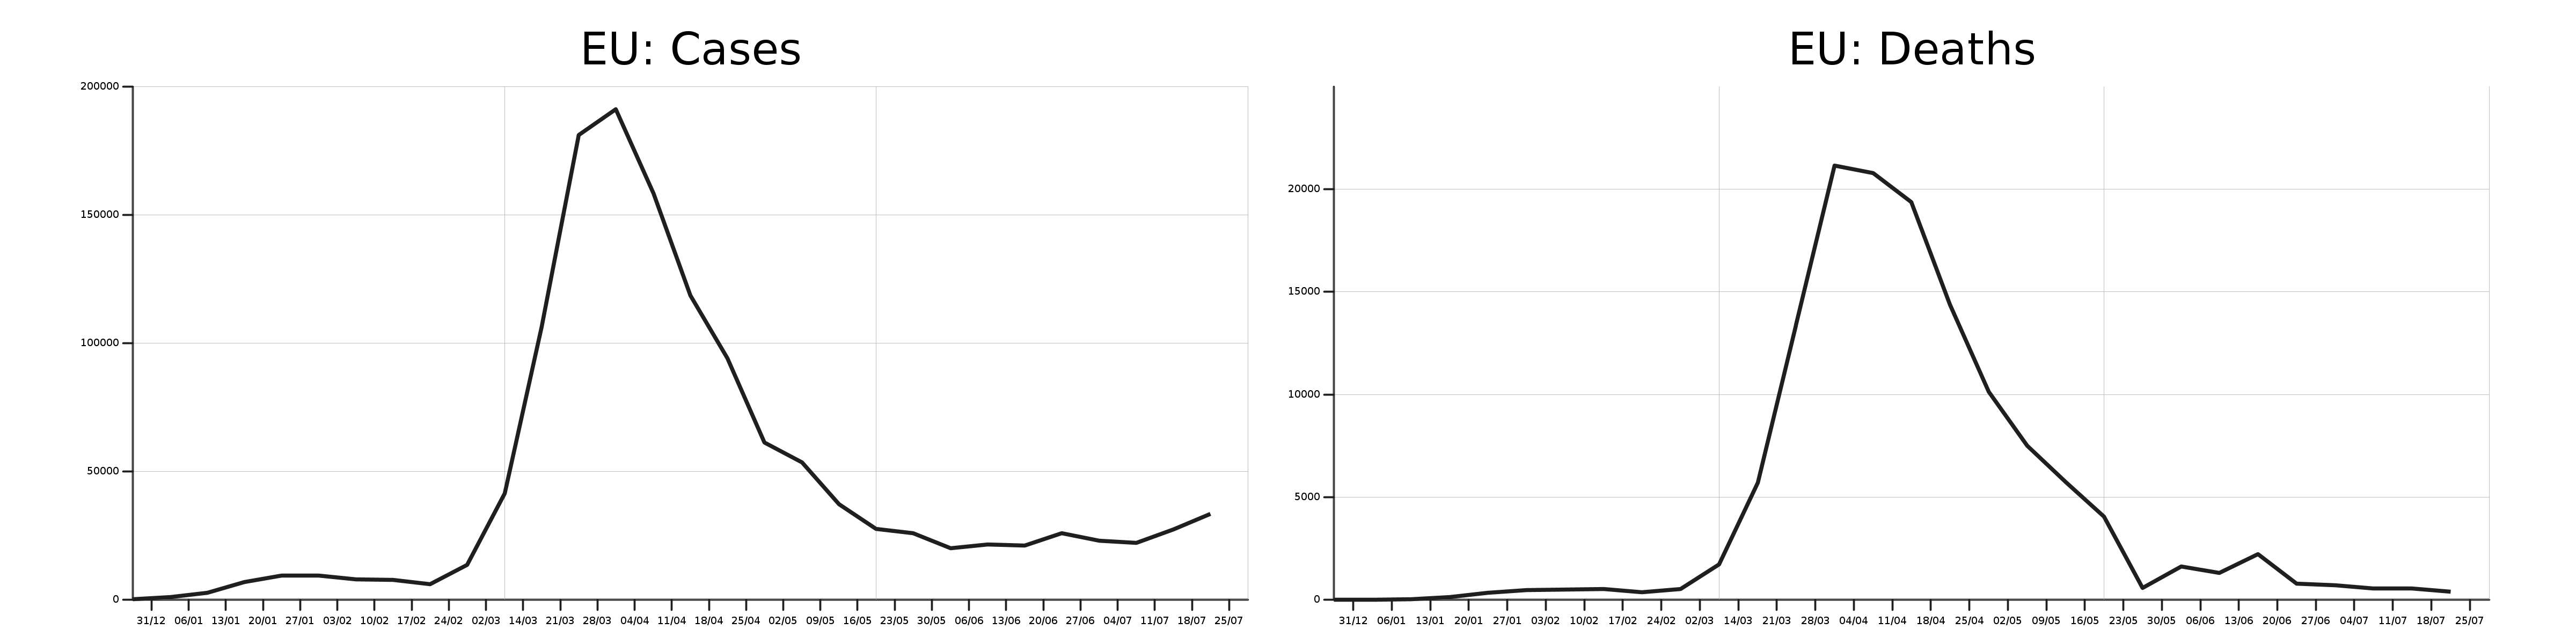

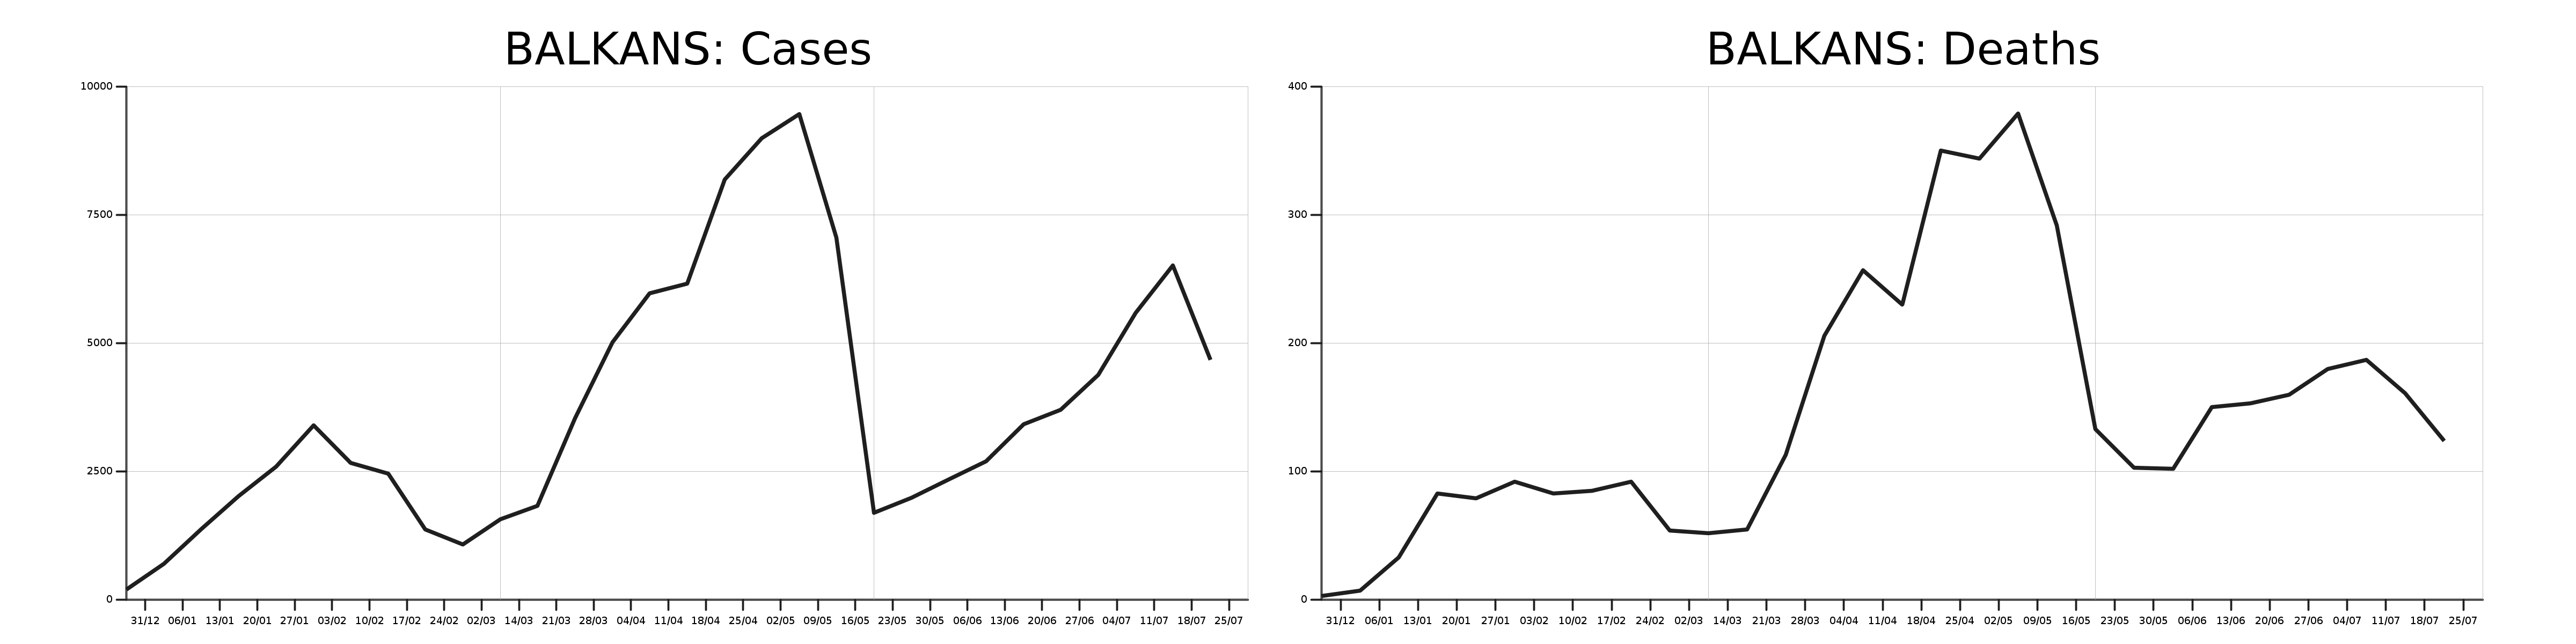

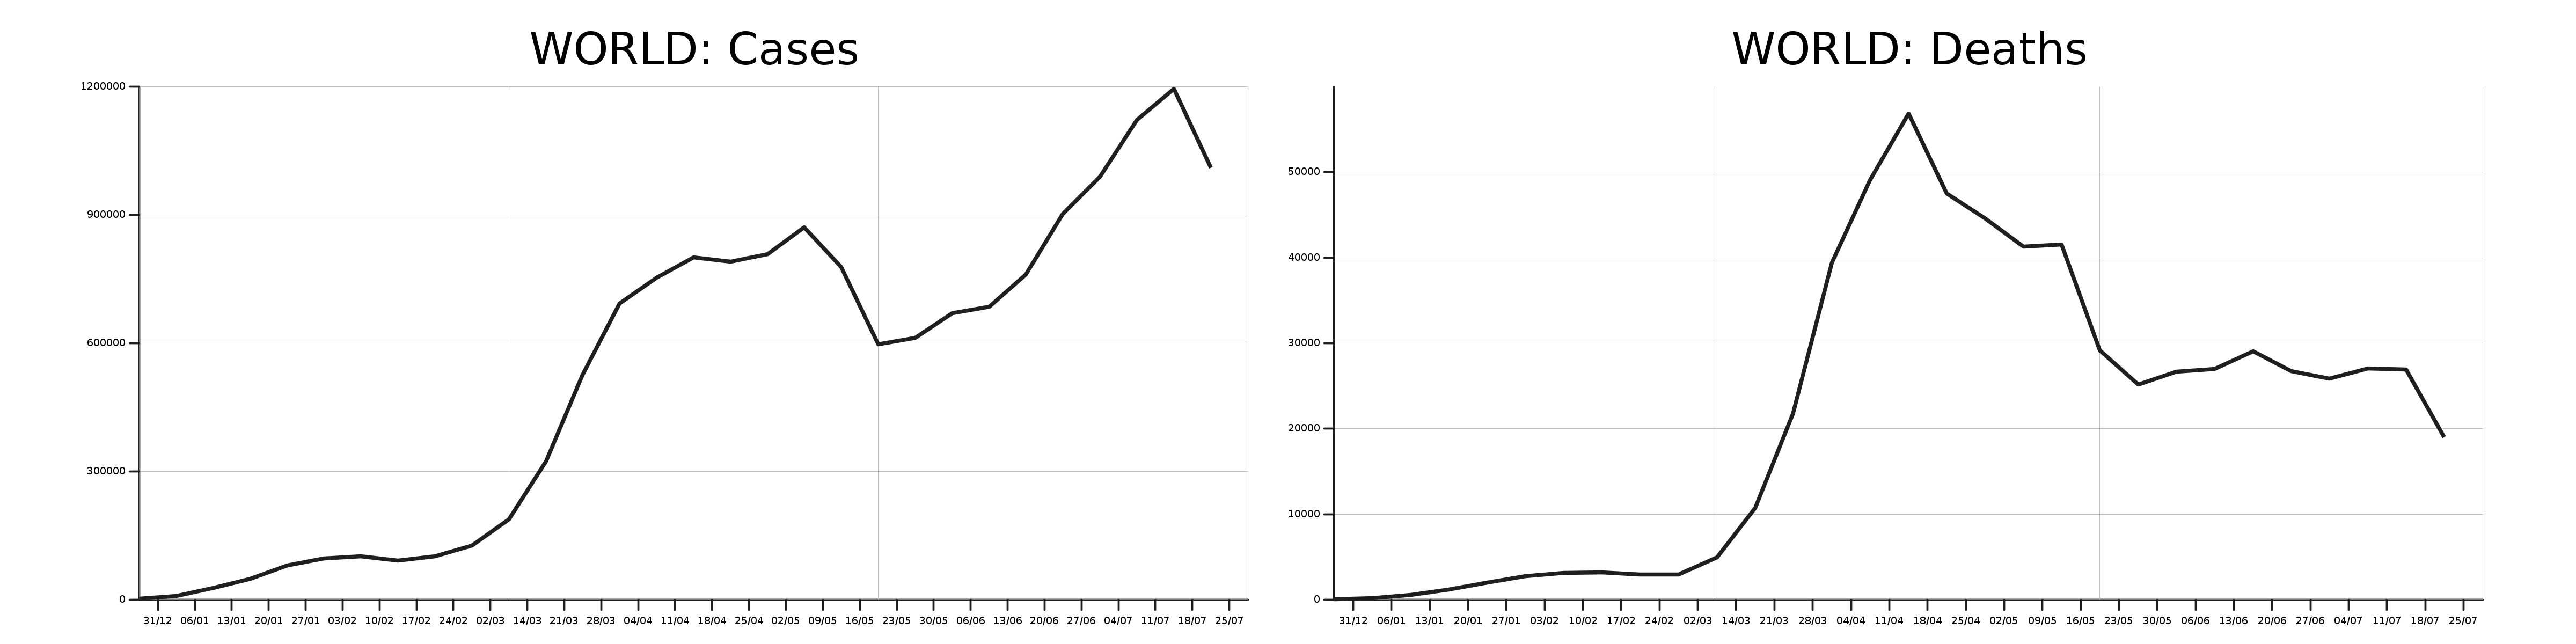

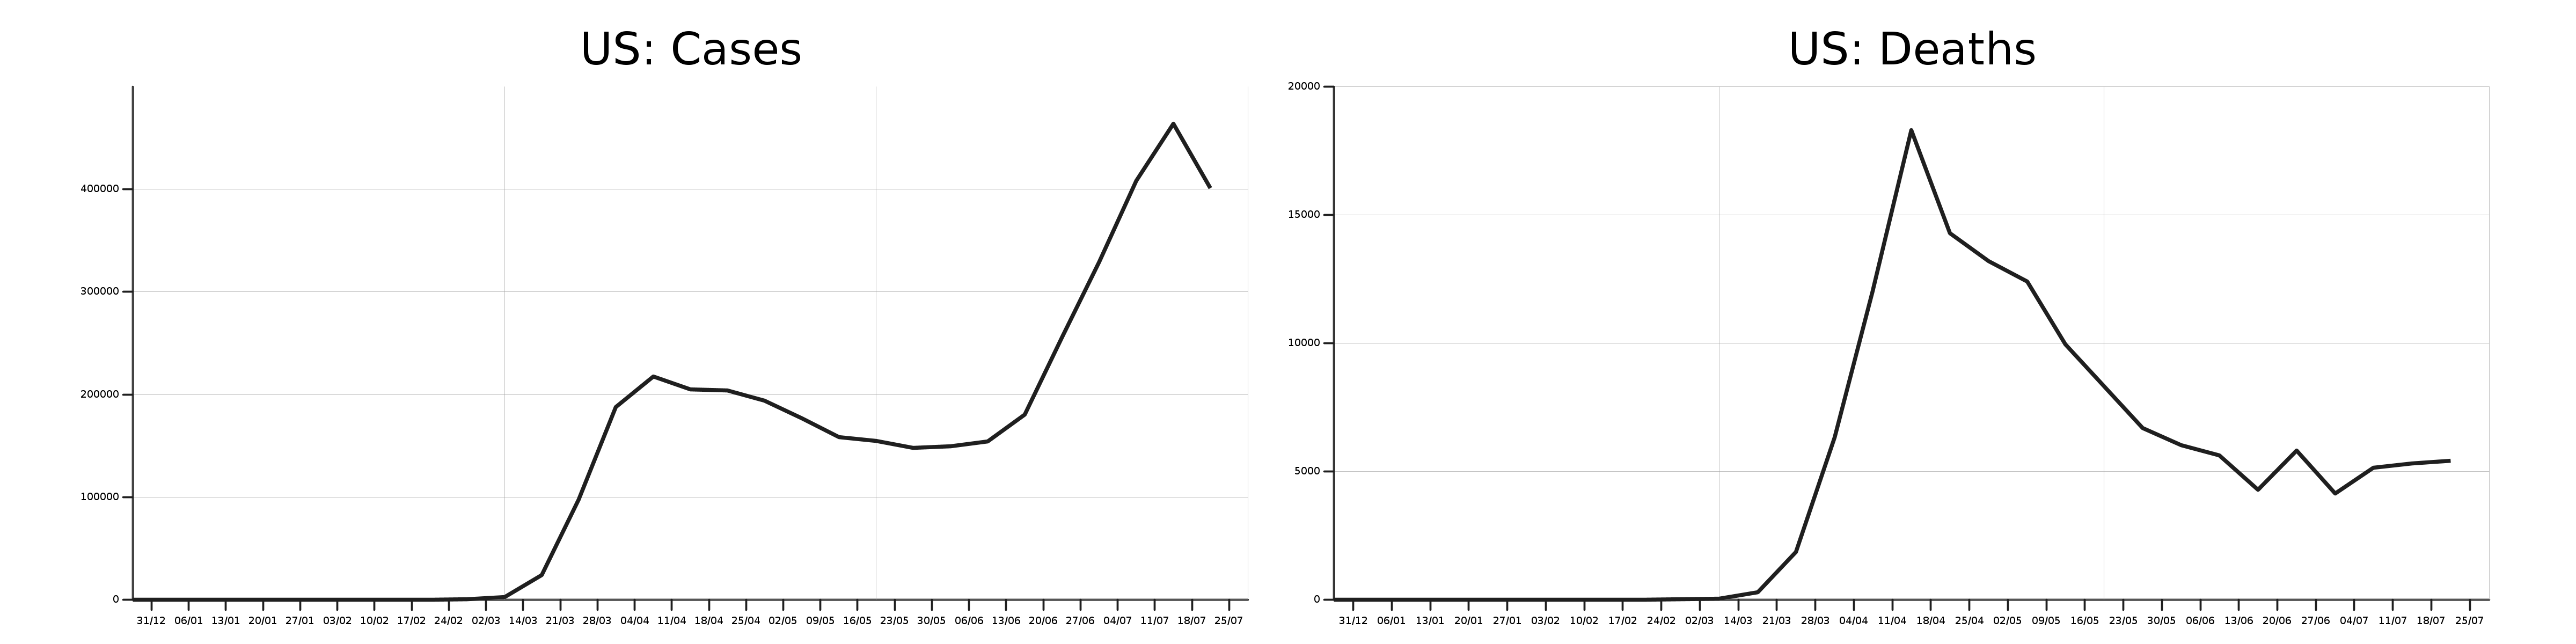

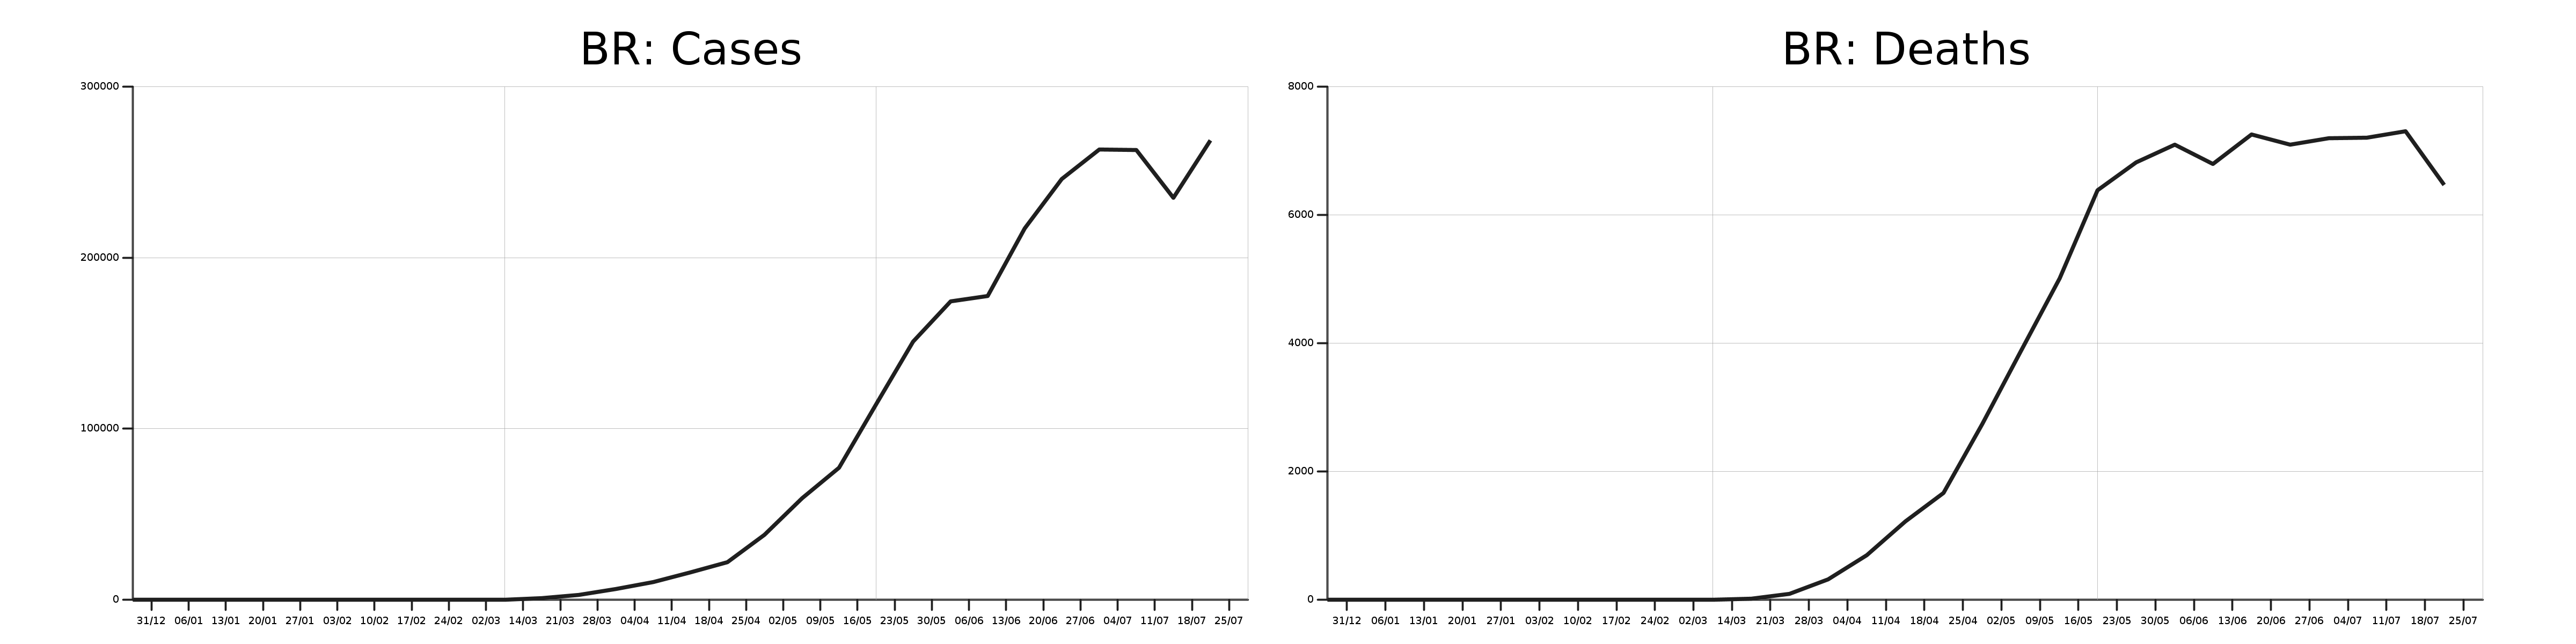

In [17]:
renderCountry("EL", df_union)
renderCountry("EU", df_union)
renderCountry("BALKANS", df_union)
renderCountry("WORLD", df_union)
renderCountry("US", df_union)
renderCountry("BR", df_union)

In [ ]:
spark.close